# Callin Switzer
### 6 June 2019
___
### - Train Dense, Feedforward Neural Network with Keras
### - Train with fully actuated system
### - Pur velocity as input to network, with only the four controls as output

___

In [67]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as colors
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
import winsound
import pickle
import glob
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
# define directories
baseDir = os.getcwd()
dataDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2019-06-12 14:53:21.080169


In [68]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

# Make training and test set

In [69]:
# read in data
trainDF = pd.read_hdf(os.path.join(dataOutput, "concatenatedRandomICs.h5"), key = "data")

In [70]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "xf" : "x_99", "yf" : "y_99", "phif" : "phi_99", "thetaf" : "theta_99", 
                        "xd0" : "x_dot_0", "yd0" : "y_dot_0", "phid0" : "phi_dot_0", "thetad0": "theta_dot_0", 
                        "xdf" : "x_dot_99", "ydf": "y_dot_99", "phidf": "phi_dot_99", "thetadf": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [133]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

# make dataset
X = trainDF.loc[:, ["phi_0", "theta_0", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0",
                   "x_99", "y_99", "phi_99", "theta_99",
                   "x_dot_99", "y_dot_99", "theta_dot_99"]]

# put phi into network "output"
Y = trainDF.loc[:, ["Fx", "Fy", "tau",  "phi_dot_99"] ]

In [134]:
X.head()

,phi_0,theta_0,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0,x_99,y_99,phi_99,theta_99,x_dot_99,y_dot_99,theta_dot_99
0,2.909070,4.539917,1240.975696,-321.289498,10.607821,5.761704,23.367432,-2.222497,4.628560,6.334514,1047.460389,-38.377027,166.050842
1,3.308109,3.243816,-1149.257088,365.093207,22.615302,16.957561,-20.768748,11.106142,4.891662,4.921125,-1075.409015,697.828947,146.364185
2,5.548527,5.436117,-1496.313673,244.869357,0.328348,7.760703,-25.280989,4.318522,-0.137526,-0.270820,-1133.713595,748.985152,-563.122968
3,0.510978,4.004344,-560.948725,86.858301,24.197259,-0.067853,-5.931729,0.748787,1.423037,4.826500,-26.956023,45.961219,72.504068
4,1.609007,6.129205,-214.455052,225.808462,9.118306,-16.195650,-9.280447,6.707153,-0.231868,4.399997,-539.671502,488.013492,-177.812751


In [135]:
Y.head()

,Fx,Fy,tau,phi_dot_99
0,-29612.961122,2498.912376,53852.149654,162.092739
1,-26336.915345,-9994.333651,66579.923810,141.667777
2,4645.636361,41785.500502,-13638.356558,-561.725041
3,-11940.326951,30568.337400,-59677.690610,77.007517
4,-34842.795622,-4409.744037,77836.665059,-183.140660


In [136]:
# test train split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state = 123)

# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xtest_scaled = scalerX.transform(Xtest)
Ytest_scaled = scalerY.transform(Ytest)

pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

,phi_0,theta_0,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0,x_99,y_99,phi_99,theta_99,x_dot_99,y_dot_99,theta_dot_99
0,-0.479611,0.002266,-0.491811,-0.220474,0.168732,0.450440,-0.318639,-0.229442,-0.094704,0.071486,-0.202153,-0.214663,0.089438
1,-0.453551,0.264615,0.469097,0.195148,0.353807,-0.446865,0.295886,0.197180,-0.188053,0.054898,0.205139,0.206023,-0.052671
2,-0.102133,-0.139825,0.486725,0.399421,0.036643,-0.265189,0.314624,0.345313,-0.234415,-0.252743,0.349240,0.295930,-0.290446
3,-0.025410,0.473391,-0.032577,-0.026313,-0.037384,-0.004011,-0.026110,0.073530,0.050494,0.209861,-0.042385,0.132223,0.083292
4,0.492691,-0.269698,-0.191459,0.408163,-0.416592,-0.057925,-0.131405,0.348033,0.118454,-0.135028,-0.084081,0.308521,-0.057788


In [119]:
# # save scalers, to be used on test set
# scalerfileX = 'scalerX_veloc.pkl'
# pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

# scalerfileY = 'scalerY_veloc.pkl'
# pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

# Keras models

In [137]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

K.clear_session()

In [138]:
# refref: start with small network and then build up
# refref: start with large network and prune

# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [32, 32, 32, 32], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization))(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh')(inputs)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [139]:
modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0.0, 
               "numUnits": [512, 512, 512, 16],
               "weightRegularization": 0.0
              }


model = create_network(**modelParams)

modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).\
                            replace("[", "").replace("]", "").replace(", ", "_")[0:-2] + "_" + datetime.now().strftime("%Y_%m_%d__%I_%M_%S") + "veloc"
print(modelName)

model.summary()

#model.get_config()
earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=50, 
                          verbose=1, mode='auto', min_delta = 0.000001)

# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

Opt_rmsprop__Dro_0.0__Num_512_512_512_16__Wei_0.0_2019_06_12__03_11_55veloc
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               7168      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                8208      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 540,756
Trainable params: 540,756
Non-trainable para

In [140]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [151]:
# # fit model without regularization
stt = time.time()
history = model.fit(Xtrain_scaled, Ytrain_scaled, epochs = 10, verbose = 2, 
                        batch_size=2**14, callbacks=[earlystop], validation_split = 0.3)
winsound.PlaySound("*", winsound.SND_ALIAS)
endd = time.time() - stt
print(endd)

Train on 5544285 samples, validate on 2376123 samples
Epoch 1/10
 - 7s - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 2/10
 - 8s - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 3/10
 - 7s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 4/10
 - 7s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 5/10
 - 7s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 6/10
 - 7s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 7/10
 - 7s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 8/10
 - 8s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 9/10
 - 8s - loss: 0.0055 - mean_squ

In [152]:
historyDict["mean_squared_error"].extend(history.history["mean_squared_error"])
historyDict["val_mean_squared_error"].extend(history.history["val_mean_squared_error"])

In [153]:
# save model and history
model.save(os.path.join(savedModels,  modelName + '.h5'))
pickle.dump(historyDict, open(os.path.join(dataOutput, modelName + "history.pkl"), "wb"))

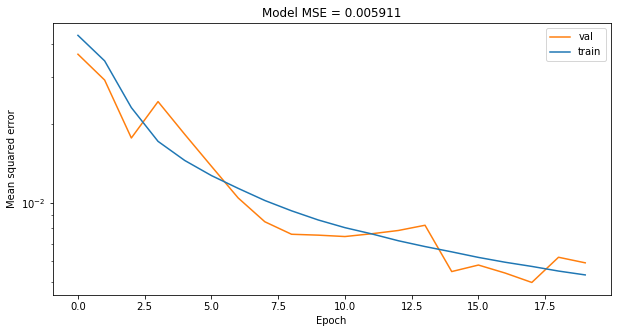

In [154]:


fig, axs = plt.subplots(1,1,figsize=(10,5))
# summarize history for accuracy
axs.plot(historyDict["val_mean_squared_error"], label = "val", color = "C1")
axs.plot(historyDict["mean_squared_error"], label = "train", color = "C0")

axs.set_title('Model MSE = '+ str((historyDict['val_mean_squared_error'][-1]))[:8])
axs.set_ylabel('Mean squared error')
axs.set_xlabel('Epoch')
axs.legend( loc='best')
plt.yscale('log') #logarithmic scale for y axis
fig.savefig(os.path.join(figDir, modelName + '_training.png'))


___

## Evaluate accuracy on test data

___

In [155]:
# from keras.models import load_model

# modelPath = os.path.join(savedModels, "Opt_rmsprop__Dro_0__Num_512_512_512_16__Wei_0_2019_06_11__11_27_06_fullActuated.h5")

# model = load_model(modelPath)

# # load scalers
# scalerX = pickle.load(open("D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput_twoTorque\scalerX_fullact.pkl", "rb"))
# scalerY = pickle.load(open("D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput_twoTorque\scalerY_fullact.pkl", "rb"))


In [156]:

# predict
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(scalerY.inverse_transform(Ytest_scaled), columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()



,Fx,Fy,tau,phi_dot_99,Fx_pred,Fy_pred,tau_pred,phi_dot_99_pred
0,-43383.349096,7777.781558,-89149.114709,191.024411,-30194.296875,3474.487793,-67703.703125,195.104080
1,-15183.324785,-33332.606636,-67061.833735,29.746681,-8493.534180,-34561.121094,-75301.640625,12.749203
2,-18573.143652,-5798.048395,60110.993478,-79.225996,-23305.623047,-17980.414062,58440.285156,-94.424675
3,3097.636077,13097.481455,-59066.505785,26.699424,2814.695068,14413.788086,-71380.664062,35.416237
4,40757.753533,2142.142946,56326.235342,232.317284,34229.675781,-13338.127930,9822.893555,226.583755


In [157]:
df_c = df_c.iloc[:1000, :]

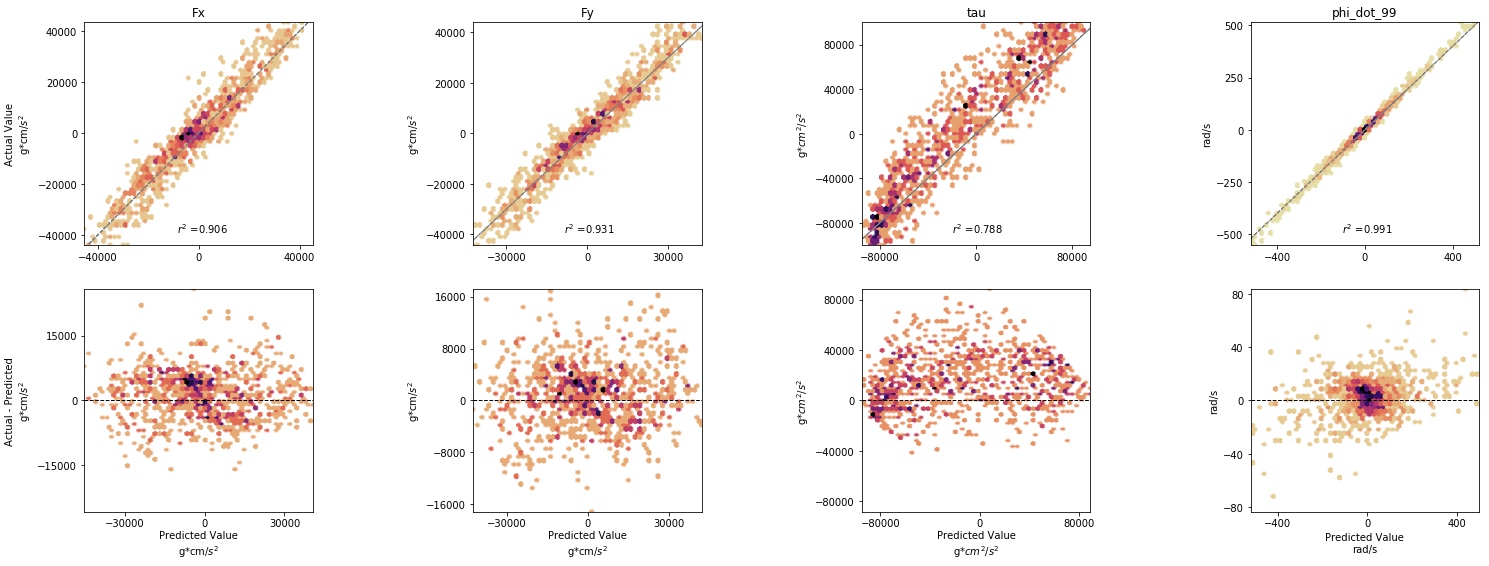

In [158]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker


plt.close("all")
fig, axs = plt.subplots(2,df_c.shape[1] //2, figsize=np.array([25, 9]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.7)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r"g*cm/$s^2$", r"g*cm/$s^2$", r"g*$cm^2$/$s^2$",  "rad/s"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, df_c.shape[1] //2):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(5))

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
                 df_c.loc[:,YtestDF.columns[ii]], 
                 'grey', linewidth = 1, linestyle  = "--")

    # annotate with R^2
    axs[ii].text(np.max(df_c.loc[:,YtestDF.columns[ii]])*-0.2, 
                 np.min(df_c.loc[:,YtestDF.columns[ii]])*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(df_c.shape[1]//2, df_c.shape[1])):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(5))
    axs[plotNum].set_xlabel("Predicted Value\n" + ylabs[jj])

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])


fig.savefig(os.path.join(figDir, "PredVActual_" + modelName + ".png"), dpi = 500, bbox_inches='tight')
plt.show()
# plt.close()

In [ ]:
# refref: look at percent residuals so that the scale isn't misleading
# refref: convert angles to pairs of values: https://stats.stackexchange.com/questions/218407/encoding-angle-data-for-neural-network

# refref:  Make video of hovering, with only the network input

In [175]:
theta = 10.5* np.pi 
anglePair = (np.sin(theta), np.cos(theta))

In [176]:
np.arctan2(anglePair[0], anglePair[1])

1.570796326794897

In [179]:
np.mod(-2*np.pi, 2*np.pi)

0.0